# Week IV: Unsupervised Anomaly Detection on Tabular Data

In this week's lesson, we are going to cover the final part on tabular data. We'll see how we can use ML for the purpose of anomaly detection, and how deep learning allows us to solve the problem in an unsupervised manner. 

Anomaly detection: identification of unusual observations which deviate significantly from the overall distribution of the data. We can think of anomaly detection as an extremely unbalanced binary classification problem.

Anomaly detection does not have to be in tabular form. Examples include: security videos, medical monitoring, and syndromic surveillance.

## Dataset

We're going to solve an anomaly detection problem for a financial dataset. We get a series of credit card transactions that happened within 2 days, and our goal is to predict whether the transaction is legitimate or fradulent.

Note that most of the features in the dataset are anonymized due to the sensitivity of financial information. This was done using a PCA transformation.


Let's begin with imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, auc, precision_recall_curve, plot_precision_recall_curve, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
tf.random.set_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Advanced Techniques in Machine Learning/Notebooks/2023/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


We have almost 300K samples, comprised of 30 variables and 1 label (Class). Normal transaction has label 0, while an anomalous sample is labeled 1.

The V1,...,V28 variables are not that interesting, since we cannot interpret them. Also, they are the result of a PCA transformation, so we expect them to behave relatively well. However, the case for "Amount" is different:

In [5]:
df[['Amount']].describe()

,Amount
count,284807.000000
mean,88.349619
std,250.120109
min,0.000000
25%,5.600000
50%,22.000000
75%,77.165000
max,25691.160000


The values change wildly. Let's look at a histogram:

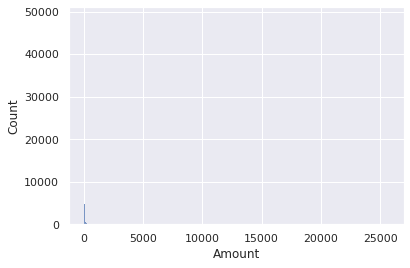

In [6]:
sns.set()
sns.histplot(df['Amount'])

Not very helpful... 

We can limit the values to relatively low ones:

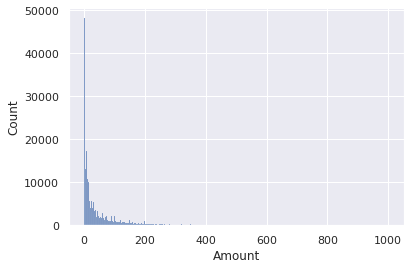

In [7]:
sns.histplot(df[df['Amount'] <= 1000]['Amount'])

Still, we miss some data. One way to solve this problem is to take the log of amount:

In [8]:
df['Amount_log'] = np.log10(df['Amount'] + 10**-10)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_log
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,2.174990
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.429752
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,2.578249
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,2.091667
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.845036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,-0.113509
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1.394277
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1.831742
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,1.000000


And the distribution is "nicer" now:

In [9]:
df[['Amount_log']].describe()

,Amount_log
count,284807.000000
mean,1.232675
std,1.212047
min,-10.000000
25%,0.748188
50%,1.342423
75%,1.887420
max,4.409784


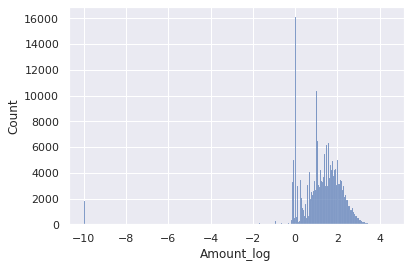

In [10]:
sns.histplot(df['Amount_log'])

There are some outliers (-10), without them:

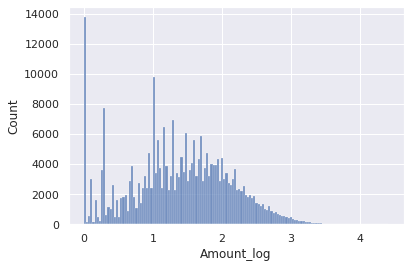

In [11]:
sns.histplot(df[df['Amount_log'] >= 0]['Amount_log'])

Usually, removing outliers is a good idea in ML. However, this is an anomaly detection problem, outliers are the most interesting samples!

Let's deal with "Time". It's easy to see that it's in seconds:

In [12]:
minutes = 172792.0 / 60
hours = minutes / 60
days = hours / 24
round(minutes), round(hours), round(days)

(2880, 48, 2)

In [13]:
df['Time'] / (60 * 60 * 48)

0         0.000000
1         0.000000
2         0.000006
3         0.000006
4         0.000012
            ...   
284802    0.999919
284803    0.999925
284804    0.999931
284805    0.999931
284806    0.999954
Name: Time, Length: 284807, dtype: float64

In [14]:
from datetime import datetime
  
datetime.fromtimestamp(172792), datetime.fromtimestamp(172793)

(datetime.datetime(1970, 1, 2, 23, 59, 52),
 datetime.datetime(1970, 1, 2, 23, 59, 53))

In [15]:
df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x))
df['Time']

0        1970-01-01 00:00:00
1        1970-01-01 00:00:00
2        1970-01-01 00:00:01
3        1970-01-01 00:00:01
4        1970-01-01 00:00:02
                 ...        
284802   1970-01-02 23:59:46
284803   1970-01-02 23:59:47
284804   1970-01-02 23:59:48
284805   1970-01-02 23:59:48
284806   1970-01-02 23:59:52
Name: Time, Length: 284807, dtype: datetime64[ns]

In [16]:
df['Hour'] =  df['Time'].apply(lambda x: x.hour / 24)
df['Minute'] =  df['Time'].apply(lambda x: x.minute / 60)
df['Second'] =  df['Time'].apply(lambda x: x.second / 60)
df[['Time', 'Hour', 'Minute', 'Second']]

,Time,Hour,Minute,Second
0,1970-01-01 00:00:00,0.000000,0.000000,0.000000
1,1970-01-01 00:00:00,0.000000,0.000000,0.000000
2,1970-01-01 00:00:01,0.000000,0.000000,0.016667
3,1970-01-01 00:00:01,0.000000,0.000000,0.016667
4,1970-01-01 00:00:02,0.000000,0.000000,0.033333
...,...,...,...,...
284802,1970-01-02 23:59:46,0.958333,0.983333,0.766667
284803,1970-01-02 23:59:47,0.958333,0.983333,0.783333
284804,1970-01-02 23:59:48,0.958333,0.983333,0.800000
284805,1970-01-02 23:59:48,0.958333,0.983333,0.800000


Remove "Amount" and "Time" after the transformations:

In [17]:
df = df.drop(['Amount', 'Time'], axis=1)
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Class,Amount_log,Hour,Minute,Second
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,2.174990,0.000000,0.000000,0.000000
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.429752,0.000000,0.000000,0.000000
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,2.578249,0.000000,0.000000,0.016667
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,2.091667,0.000000,0.000000,0.016667
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.141267,-0.206010,0.502292,0.219422,0.215153,0,1.845036,0.000000,0.000000,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.113509,0.958333,0.983333,0.766667
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,1.394277,0.958333,0.983333,0.783333
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,1.831742,0.958333,0.983333,0.800000
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.123205,-0.569159,0.546668,0.108821,0.104533,0,1.000000,0.958333,0.983333,0.800000


Let's look at anomalous vs. normal samples:

In [18]:
anomalous_df = df[df['Class'] == 1]
normal_df = df[df['Class'] == 0]

In [19]:
anomalous_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Class,Amount_log,Hour,Minute,Second
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.320198,0.044519,0.177840,0.261145,-0.143276,1,-1.000000e+01,0.000000,0.100000,0.766667
623,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1,2.723456e+00,0.000000,0.116667,0.866667
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1,2.380085e+00,0.041667,0.233333,0.366667
6108,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,-0.053502,0.252405,-0.657488,-0.827136,0.849573,1,1.770852e+00,0.041667,0.933333,0.433333
6329,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-1.632653,1.488901,0.566797,-0.010016,0.146793,1,4.342945e-11,0.083333,0.083333,0.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,...,-0.294885,0.537503,0.788395,0.292680,0.147968,1,2.591065e+00,0.916667,0.983333,0.033333
280143,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,-0.081049,0.521875,0.739467,0.389152,0.186637,1,-1.191864e-01,0.958333,0.033333,0.450000
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.032070,-0.739695,0.471111,0.385107,0.194361,1,1.891482e+00,0.958333,0.033333,0.516667
281144,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,...,-0.183659,-0.328168,0.606116,0.884876,-0.253700,1,2.389166e+00,0.958333,0.200000,0.766667


In [20]:
normal_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Class,Amount_log,Hour,Minute,Second
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,2.174990,0.000000,0.000000,0.000000
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.429752,0.000000,0.000000,0.000000
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,2.578249,0.000000,0.000000,0.016667
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,2.091667,0.000000,0.000000,0.016667
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.141267,-0.206010,0.502292,0.219422,0.215153,0,1.845036,0.000000,0.000000,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.113509,0.958333,0.983333,0.766667
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,1.394277,0.958333,0.983333,0.783333
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,1.831742,0.958333,0.983333,0.800000
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.123205,-0.569159,0.546668,0.108821,0.104533,0,1.000000,0.958333,0.983333,0.800000


In [21]:
percentage_normal_samples = normal_df.shape[0] / (normal_df.shape[0] + anomalous_df.shape[0]) * 100
print(f'Percentage of normal samples is: {str(round(percentage_normal_samples, 2))}%')

Percentage of normal samples is: 99.83%


Highly imbalanced!

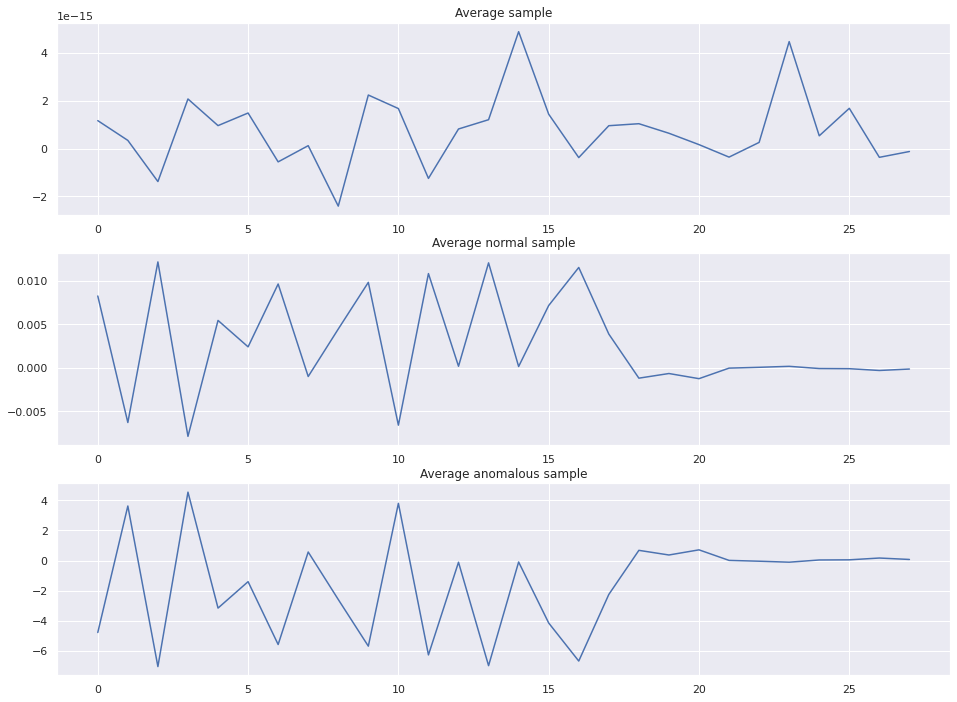

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

axes[0].set_title('Average sample')
axes[0].plot(range(normal_df.shape[1] - 5), df.drop(['Amount_log', 'Class', 'Hour', 'Minute',	'Second'], axis=1).mean())

axes[1].set_title('Average normal sample')
axes[1].plot(range(normal_df.shape[1] - 5), normal_df.drop(['Amount_log', 'Class', 'Hour', 'Minute',	'Second'], axis=1).mean())

axes[2].set_title('Average anomalous sample')
axes[2].plot(range(normal_df.shape[1] - 5), anomalous_df.drop(['Amount_log', 'Class', 'Hour', 'Minute',	'Second'], axis=1).mean())

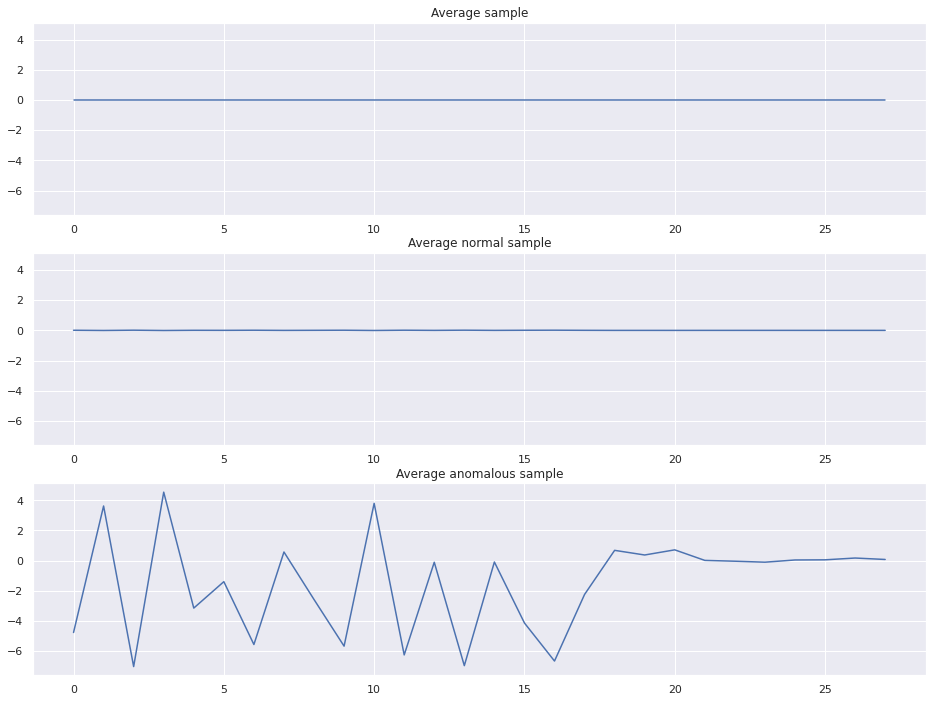

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharey=True)

axes[0].set_title('Average sample')
axes[0].plot(range(normal_df.shape[1] - 5), df.drop(['Amount_log', 'Class', 'Hour', 'Minute',	'Second'], axis=1).mean())

axes[1].set_title('Average normal sample')
axes[1].plot(range(normal_df.shape[1] - 5), normal_df.drop(['Amount_log', 'Class', 'Hour', 'Minute',	'Second'], axis=1).mean())

axes[2].set_title('Average anomalous sample')
axes[2].plot(range(normal_df.shape[1] - 5), anomalous_df.drop(['Amount_log', 'Class', 'Hour', 'Minute',	'Second'], axis=1).mean())

In [24]:
data = df.drop(['Class'], axis=1).values
labels = df['Class'].values

# XGBoost

We can treat this problem as a standard supervised binary classification problem:

In [213]:
x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=123, stratify=labels
)

This time, we'll use XGBoost:

In [270]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import datetime

begin_time = datetime.datetime.now()

params = {'max_depth': [3, 6, 10],
          'learning_rate': [0.5, 1],
          'n_estimators': [100]}
xgbc = XGBClassifier(objective='binary:logistic', random_state=20)
clf = GridSearchCV(estimator=xgbc, 
                   param_grid=params,
                   scoring='roc_auc', 
                   verbose=10)
clf.fit(x_train, y_train)
time1 = (datetime.datetime.now() - begin_time).total_seconds()
print('Done grid search after: ', time1, ' seconds')

print("Best parameters:", clf.best_params_)
best_model = clf.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START learning_rate=0.5, max_depth=3, n_estimators=100............
[CV 1/5; 1/6] END learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.982 total time=  39.9s
[CV 2/5; 1/6] START learning_rate=0.5, max_depth=3, n_estimators=100............
[CV 2/5; 1/6] END learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.984 total time=  40.2s
[CV 3/5; 1/6] START learning_rate=0.5, max_depth=3, n_estimators=100............
[CV 3/5; 1/6] END learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.982 total time=  39.9s
[CV 4/5; 1/6] START learning_rate=0.5, max_depth=3, n_estimators=100............
[CV 4/5; 1/6] END learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.987 total time=  40.0s
[CV 5/5; 1/6] START learning_rate=0.5, max_depth=3, n_estimators=100............
[CV 5/5; 1/6] END learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.982 total time=  38.6s
[CV 1/5; 2/6] START learning_rate=0

In [271]:
y_pred = best_model.predict(x_test)

Accuracy: (TP + TN) / (P + N)

Precision: TP / (TP + FP)

Recall: TP / P

In [272]:
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))

Accuracy:  0.9994733330992591
Precision:  0.9473684210526315
Recall:  0.7346938775510204


In [29]:
y_pred_prob = best_model.predict_proba(x_test)
y_pred_prob

array([[9.9996066e-01, 3.9352566e-05],
       [9.9996525e-01, 3.4727091e-05],
       [9.9996525e-01, 3.4727091e-05],
       ...,
       [9.9776226e-01, 2.2377647e-03],
       [9.9996525e-01, 3.4727091e-05],
       [9.9996525e-01, 3.4727091e-05]], dtype=float32)

In [30]:
np.argmax(y_pred_prob, axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
roc_auc_score(y_test, np.argmax(y_pred_prob, axis=1))

0.8417927701468882

In [32]:
precision_recall_curve(y_test, np.argmax(y_pred_prob, axis=1))

(array([0.00172045, 0.93055556, 1.        ]),
 array([1.        , 0.68367347, 0.        ]),
 array([0, 1]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


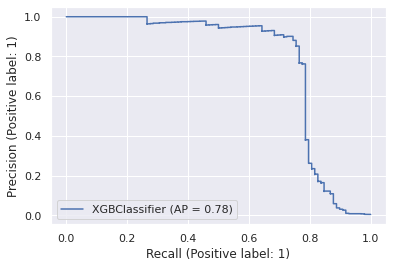

In [33]:
plot_precision_recall_curve(best_model, x_test, y_test)

## Unsupervised

What happens if we don't have labels? 

Consider the following case: the credit card company has given us data for 2 days. They haven't identified any frauds in this time period. Now they ask us to use this data to detect anomalies on a different day that might contain frauds. How can we do that?

Obviously, XGBoost or random forest are off the table. We'll use deep learning, and more specifically autoencoders.

But first, let's remove the time features to make the scenario more realistic:

In [34]:
normal_df = normal_df.drop(['Hour', 'Minute', 'Second'], axis=1)
anomalous_df = anomalous_df.drop(['Hour', 'Minute', 'Second'], axis=1)

In [35]:
normal_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_log
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,2.174990
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.429752
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,2.578249
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,2.091667
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,1.845036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.113509
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,1.394277
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,1.831742
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,1.000000


In [36]:
anomalous_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_log
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,1,-1.000000e+01
623,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1,2.723456e+00
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1,2.380085e+00
6108,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,1,1.770852e+00
6329,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1,4.342945e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,1,2.591065e+00
280143,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,1,-1.191864e-01
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,1,1.891482e+00
281144,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,1,2.389166e+00


### Autoencoders

The idea behind autoencoders is to take an input and reconstruct it. An auto encoder has two main parts: and encoder and a decoder. THe encoder takes a high-dimensional input and transforms it to a low dimensional one (an encoded value). The decoder does the opposite (a decoded value).

Autoencoders were orignially used for representation learning (feature learning) as a method to reduce dimensionality. However, they have many variations and applications. The interesting attribute to our problem, is the fact that autoencoders are unsupervised.

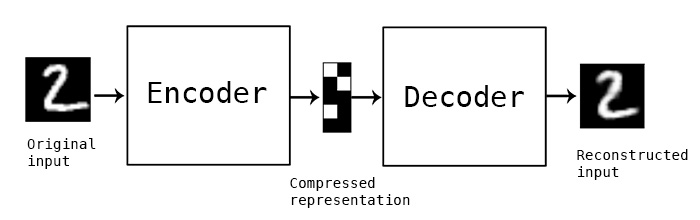


(https://blog.keras.io/building-autoencoders-in-keras.html)

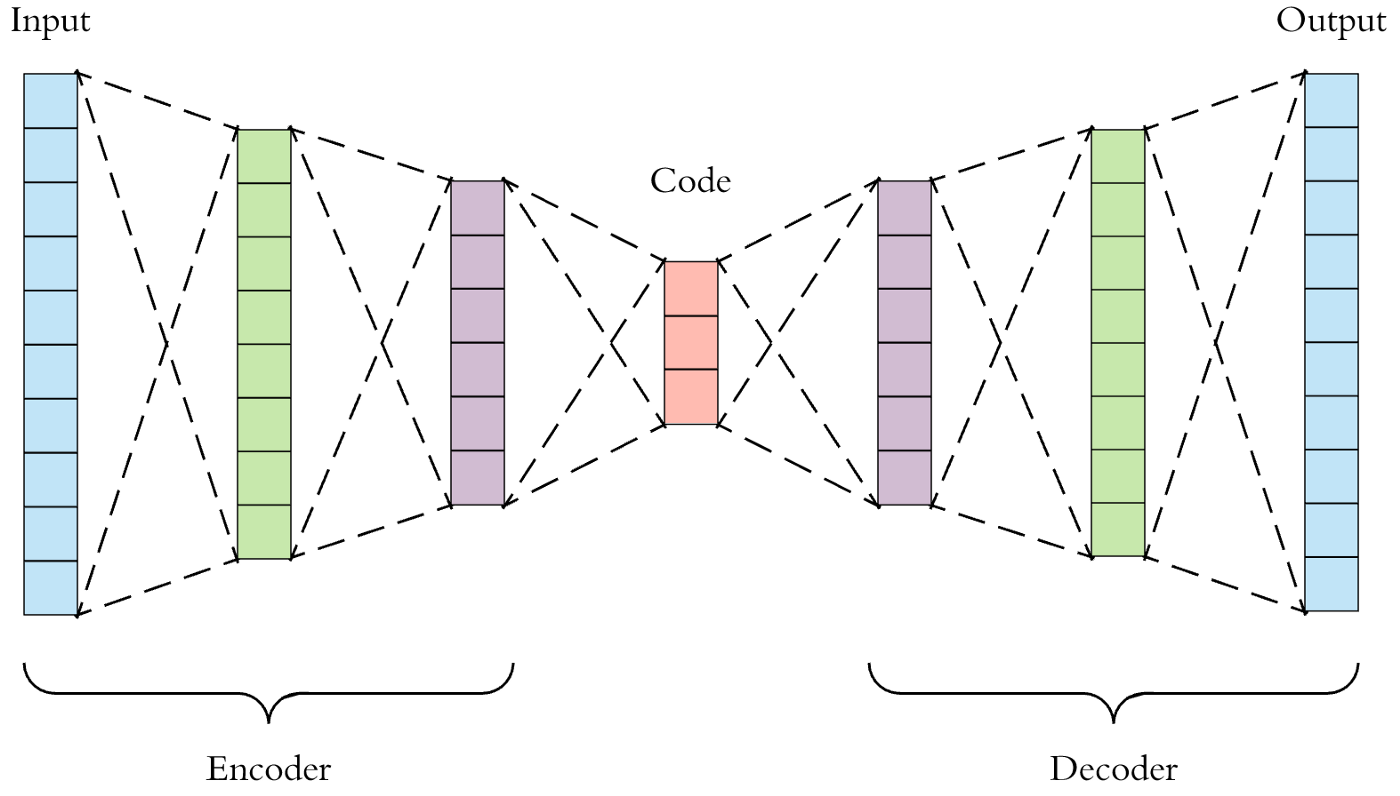



(https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798)

### Autoencoders for anomaly detection

A good autoencoder is a model that reconstructs the input very well, i.e. with a very small error. 

If we train an autoencoder only an normal samples, that it should be able to reconstruct them well. However, during inference, when we'll use the autoencoder on an anomalous sample, the reconstruction error should be high because the model had not seen any such samples.

Split to normal vs. anomalous arrays:

In [37]:
normal_data = normal_df.drop(['Class'], axis=1).values
normal_labels = normal_df['Class'].values

In [38]:
anomalous_data = anomalous_df.drop(['Class'], axis=1).values
anomalous_labels = anomalous_df['Class'].values

Train-test-val split (no stratify here):

In [39]:
normal_train_data, normal_test_data, normal_train_labels, normal_test_labels = train_test_split(
    normal_data, normal_labels, test_size=0.2, random_state=123
)

In [40]:
normal_test_data, normal_val_data, normal_test_labels, normal_val_labels = train_test_split(
    normal_test_data, normal_test_labels, test_size=0.5, random_state=123
)

Verify dimensions:

In [41]:
normal_test_data.shape, normal_test_labels.shape

((28431, 29), (28431,))

In [42]:
normal_test_data.shape[0] + anomalous_data.shape[0]

28923

Now, add all anomalous samples to the test set, so that the model wouldn't observe any anomalies during training:

In [43]:
test_data = np.concatenate([normal_test_data, anomalous_data])
test_data.shape

(28923, 29)

In [44]:
test_labels = np.concatenate([normal_test_labels, anomalous_labels])
test_labels.shape

(28923,)

Normalize and scale:

In [45]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

normal_train_data = pipeline.fit_transform(normal_train_data)
normal_val_data = pipeline.transform(normal_val_data)
test_data = pipeline.transform(test_data)

normal_test_data = pipeline.transform(normal_test_data)

In [46]:
input_dim = normal_train_data.shape[1]

In [47]:
autoencoder = tf.keras.models.Sequential([
    
    # Encoder
    tf.keras.layers.Dense(input_dim, activation='relu', input_shape=(input_dim,)), 
    tf.keras.layers.Dense(128, activation='relu'),

    # Code
    tf.keras.layers.Dense(64, activation='tanh', name='encoding'),
    
    # Decoder
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='sigmoid')
    
])

In [48]:
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                870       
                                                                 
 dense_1 (Dense)             (None, 128)               3840      
                                                                 
 encoding (Dense)            (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 29)                3741      
                                                                 
Total params: 25,027
Trainable params: 25,027
Non-trainable params: 0
_________________________________________________________________


In [52]:
log_subdir = datetime.datetime.now().strftime('%Y%m%d%H%M')

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder.h5',
    save_best_only=True,
    monitor='val_loss',
    verbose=1,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    update_freq='epoch'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=10**-7,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

callbacks = [early_stop, save_model, tensorboard, reduce_lr]

In [53]:
autoencoder.fit(
    normal_train_data, normal_train_data,
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    validation_data=(normal_val_data, normal_val_data)
)

Epoch 1/100
873/889 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 1: val_loss improved from inf to 0.00066, saving model to autoencoder.h5
889/889 [==============================] - 6s 3ms/step - loss: 0.0037 - val_loss: 6.6214e-04 - lr: 0.0010
Epoch 2/100
882/889 [============================>.] - ETA: 0s - loss: 4.9735e-04
Epoch 2: val_loss improved from 0.00066 to 0.00041, saving model to autoencoder.h5
889/889 [==============================] - 3s 3ms/step - loss: 4.9674e-04 - val_loss: 4.0512e-04 - lr: 0.0010
Epoch 3/100
883/889 [============================>.] - ETA: 0s - loss: 3.5305e-04
Epoch 3: val_loss improved from 0.00041 to 0.00032, saving model to autoencoder.h5
889/889 [==============================] - 3s 4ms/step - loss: 3.5260e-04 - val_loss: 3.1998e-04 - lr: 0.0010
Epoch 4/100
877/889 [============================>.] - ETA: 0s - loss: 2.9107e-04
Epoch 4: val_loss improved from 0.00032 to 0.00028, saving model to autoencoder.h5
889/889 [=============

### Evaluate reconstruction quality

In [54]:
reconstructions = autoencoder.predict(test_data, verbose=1, batch_size=512)

57/57 [==============================] - 0s 2ms/step


In [55]:
train_reconstructions = autoencoder.predict(normal_train_data, verbose=1, batch_size=512)

445/445 [==============================] - 1s 2ms/step


In [56]:
reconstructions.shape, train_reconstructions.shape

((28923, 29), (227452, 29))

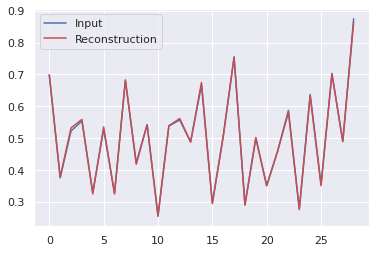

In [57]:
plt.plot(normal_train_data[100], 'b')
plt.plot(train_reconstructions[100], 'r')
plt.legend(labels=["Input", "Reconstruction"])
plt.show()

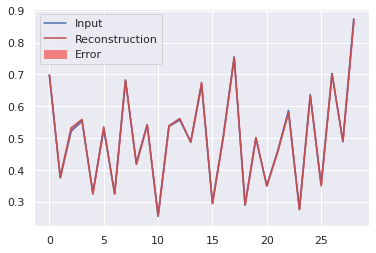

In [58]:
plt.plot(normal_train_data[100], 'b')
plt.plot(train_reconstructions[100], 'r')
plt.fill_between(np.arange(train_reconstructions.shape[1]), train_reconstructions[100], normal_train_data[100], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

In [59]:
anomalous_samples = test_data[np.where(test_labels == 1)]
anomalous_samples.shape

(492, 29)

In [60]:
anomaly_reconstructions = autoencoder.predict(anomalous_samples, verbose=1, batch_size=512)

1/1 [==============================] - 0s 17ms/step


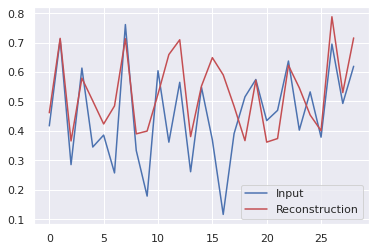

In [61]:
plt.plot(anomalous_samples[100], 'b')
plt.plot(anomaly_reconstructions[100], 'r')
plt.legend(labels=["Input", "Reconstruction"])
plt.show()

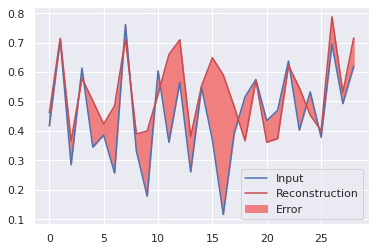

In [62]:
plt.plot(anomalous_samples[100], 'b')
plt.plot(anomaly_reconstructions[100], 'r')
plt.fill_between(np.arange(train_reconstructions.shape[1]), anomaly_reconstructions[100], anomalous_samples[100], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

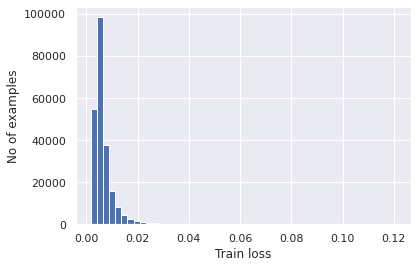

In [63]:
train_loss = tf.keras.losses.mae(train_reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

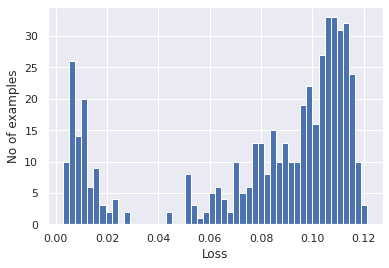

In [64]:
anomaly_loss = tf.keras.losses.mae(anomaly_reconstructions, anomalous_samples)

plt.hist(anomaly_loss[None,:], bins=50)
plt.xlabel("Loss")
plt.ylabel("No of examples")
plt.show()

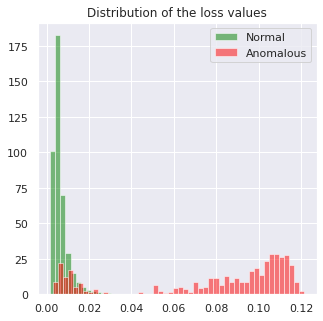

In [65]:
fig, ax = plt.subplots(figsize=(5,5))

ax.hist(train_loss, bins=50, density=True, label="Normal", alpha=0.5, color="green")
ax.hist(anomaly_loss, bins=50, density=True, label="Anomalous", alpha=0.5, color="red")

plt.title("Distribution of the loss values")
plt.legend()
plt.show()

In [66]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.011070557990791742


In [67]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(threshold, loss)

def calculate_metrics(predictions, labels):
  return {"Accuracy": accuracy_score(labels, predictions), "Precision": precision_score(labels, predictions), "Recall": recall_score(labels, predictions)}

In [68]:
thresholds = np.mean(train_loss) + np.linspace(0, 15, 25) * np.std(train_loss)
metrics = {}
confusion_matrices = []
for threshold in thresholds:
  preds = predict(autoencoder, test_data, threshold)
  metrics[threshold] = calculate_metrics(preds.numpy(), test_labels)
  confusion_matrices.append(confusion_matrix(preds.numpy(), test_labels))

In [69]:
metrics_df = pd.DataFrame(metrics).T
metrics_df.index.rename('Threshold', inplace=True) 
metrics_df

,Accuracy,Precision,Recall
Threshold,,,
0.006586,0.683262,0.048725,0.951220
0.009389,0.855444,0.096831,0.900407
0.012192,0.921481,0.160884,0.857724
0.014994,0.953117,0.244681,0.841463
0.017797,0.970542,0.346416,0.825203
0.020600,0.979705,0.447281,0.819106
0.023403,0.984995,0.539084,0.813008
0.026205,0.989213,0.646104,0.808943
0.029008,0.991529,0.726606,0.804878


In [70]:
confusion_matrices[8]

array([[28282,    96],
       [  149,   396]])

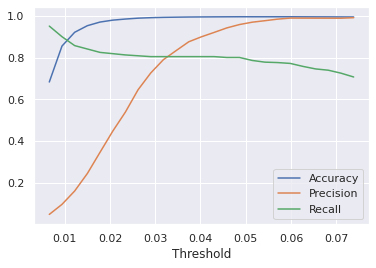

In [71]:
metrics_df.plot()

## Understanding represntations

We can look at intermediate layers:

In [82]:
autoencoder.get_layer('encoding')

In [84]:
representation_model = tf.keras.models.Model(inputs=[autoencoder.inputs], outputs=[autoencoder.get_layer('encoding').output])

In [86]:
representations = representation_model.predict(test_data, verbose=1, batch_size=512)
representations.shape

57/57 [==============================] - 0s 2ms/step


(28923, 64)

In [87]:
anomalous_representations = representations[np.where(test_labels == 1)]
normal_representations = representations[np.where(test_labels == 0)]

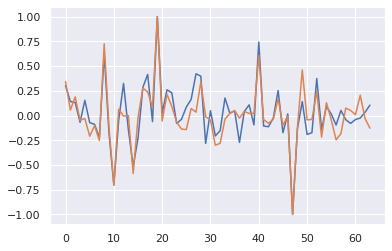

In [93]:
plt.plot(np.mean(anomalous_representations, axis=0))
plt.plot(np.mean(normal_representations, axis=0))

In [254]:
full_representations = np.concatenate([normal_representations, anomalous_representations])
full_representations.shape

(28923, 64)

In [226]:
small_autoencoder = tf.keras.models.Sequential([
    
    # Encoder
    tf.keras.layers.Dense(128, activation='relu', input_shape=(32,)), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),

    # Code
    tf.keras.layers.Dense(8, activation='tanh', name='encoding'),
    
    # Decoder
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='sigmoid')
    
])

In [227]:
small_autoencoder.compile(optimizer="adam", loss="mse")
small_autoencoder.summary()

small_autoencoder.fit(
    data, data,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr]
)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 128)               4224      
                                                                 
 dense_73 (Dense)            (None, 64)                8256      
                                                                 
 dense_74 (Dense)            (None, 32)                2080      
                                                                 
 dense_75 (Dense)            (None, 16)                528       
                                                                 
 encoding (Dense)            (None, 8)                 136       
                                                                 
 dense_76 (Dense)            (None, 16)                144       
                                                                 
 dense_77 (Dense)            (None, 32)              

In [228]:
small_representation_model = tf.keras.models.Model(inputs=[small_autoencoder.inputs], outputs=[small_autoencoder.get_layer('encoding').output])

In [229]:
small_representations = small_representation_model.predict(data, verbose=1, batch_size=512)
data.shape

557/557 [==============================] - 1s 1ms/step


(284807, 32)

In [230]:
representations_small_train = small_representation_model.predict(x_train, verbose=1, batch_size=512)
representations_small_train.shape

446/446 [==============================] - 1s 1ms/step


(227845, 8)

In [231]:
representations_small_test = small_representation_model.predict(x_test, verbose=1, batch_size=512)

112/112 [==============================] - 0s 2ms/step


In [232]:
x_train_rep, x_test_rep, y_train, y_test = train_test_split(
    small_representations, labels, test_size=0.2, random_state=123, stratify=labels
)

In [267]:
begin_time = datetime.datetime.now()

params = {'max_depth': [3, 6, 10],
          'learning_rate': [0.5, 1],
          'n_estimators': [100]}
xgbc = XGBClassifier(objective='binary:logistic', random_state=20)
clf = GridSearchCV(estimator=xgbc, 
                   param_grid=params,
                   scoring='roc_auc', 
                   verbose=10)
clf.fit(x_train_rep, y_train)
time1 = (datetime.datetime.now() - begin_time).total_seconds()
print('Done grid search after: ', time1, ' seconds')

print("Best parameters:", clf.best_params_)
best_model = clf.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START learning_rate=0.5, max_depth=3, n_estimators=100............
[CV 1/5; 1/6] END learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.967 total time=  12.9s
[CV 2/5; 1/6] START learning_rate=0.5, max_depth=3, n_estimators=100............
[CV 2/5; 1/6] END learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.976 total time=  11.6s
[CV 3/5; 1/6] START learning_rate=0.5, max_depth=3, n_estimators=100............
[CV 3/5; 1/6] END learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.960 total time=  11.7s
[CV 4/5; 1/6] START learning_rate=0.5, max_depth=3, n_estimators=100............
[CV 4/5; 1/6] END learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.975 total time=  11.5s
[CV 5/5; 1/6] START learning_rate=0.5, max_depth=3, n_estimators=100............
[CV 5/5; 1/6] END learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.940 total time=  11.4s
[CV 1/5; 2/6] START learning_rate=0

In [268]:
y_pred = best_model.predict(x_test_rep)

In [269]:
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))

Accuracy:  0.9993328885923949
Precision:  0.8846153846153846
Recall:  0.7040816326530612
